In [27]:
#pip install torch

In [28]:
import torch
import numpy as np
import random

from sklearn.metrics import confusion_matrix
import seaborn

#сделаем инициализацию random seed,
#чтобы наши эксперименты были воспроизводимы

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

In [29]:
#скачивание датасета для классификации изображений
from torchvision.datasets import MNIST
path='./'
path='/tmp'
MNIST_train = MNIST(path, download = True, train = True)
MNIST_test = MNIST(path, download = True, train = False)

In [30]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

In [31]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [32]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [33]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

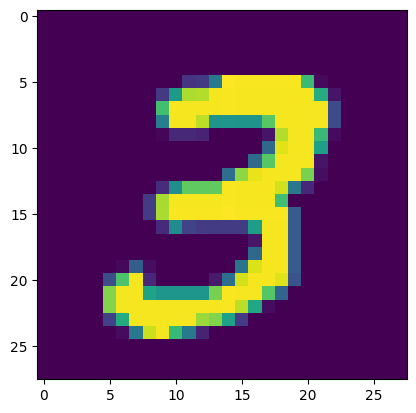

tensor(3)


In [34]:
#посмотрим на картинки
import matplotlib.pyplot as plt
plt.imshow(X_train[7, :, :])
plt.show()
print(y_train[7])

In [35]:
#у нас трехмерный тензор, мы хотим двумерный тензор,
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 784 пикселя

X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print(X_train)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [36]:
#Создание сети
# на выходе у нас числа от 0 до 9
class MNISTnet(torch.nn.Module):
  def __init__(self):
    super (MNISTnet, self).__init__()
    #Ваш_Код_Здесь
    self.fc1 = torch.nn.Linear(784,500)
    self.fc2 = torch.nn.Linear(500,100)
    self.fc3 = torch.nn.Linear(100,10)
    #self.relu=torch.nn.ReLU()
    self.sm = torch.nn.Softmax(dim=1)


  def forward(self, x):
    x=self.fc1(x)
    x=torch.nn.functional.relu(x)
    x=self.fc2(x)
    x=torch.nn.functional.relu(x)
    x=self.fc3(x)
    x = self.sm(x)
    return x


  def predict(self,x):
    with torch.no_grad():
        x=self.forward(x)
        #x=x.data.max(1)[1]
    return x




In [37]:
#есть ли видеокарта?
torch.cuda.is_available()

True

In [38]:
#смотрим, занята ли карта какими либо вычислениями
!nvidia-smi

Mon Mar  4 11:37:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0              27W /  70W |    467MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [39]:
""" теперь нужно переложить вычисления на видеокарту"""

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [40]:
#y_train=y_train.type(torch.LongTensor) 
y_train = y_train.to(device)


X_train = X_train.to(device)
X_test = X_test.to(device)

#y_test=y_test.type(torch.LongTensor) 
y_test = y_test.to(device)


In [41]:
net1 = MNISTnet()
net1 = net1.to(device)
#лосс функция
loss = torch.nn.CrossEntropyLoss()
#оптимизатор
opt = torch.optim.Adam(net1.parameters(), lr = 0.001)

In [42]:
def learn_plot(net, opt, loss, batch_size=64, epochs=10):
    batch_size = batch_size
    epochs = epochs
    net=net

    trn_loss = []
    val_loss = []

    '''данные тренировочной выборки будем перекладывать на cuda по батчам'''
    for epoch in range(epochs):
      order = np.random.permutation(len(X_train))
      for start_index in range (0,len(X_train), batch_size):
        opt.zero_grad()#зануляем градиенты

        #далее загружаем данные в forward (Получаем выходы сети)
        y_pred = net.forward(X_train[start_index:start_index+batch_size])

        loss_tr = loss(y_pred, y_train[start_index:start_index+batch_size])
        trn_loss.append(loss_tr.cpu().data.item())

        y_pred = net.predict(X_test)
        loss_val = loss(y_pred, y_test)
        val_loss.append(loss_val.cpu().data.item())

        loss_tr.backward()

        opt.step()
        
    plt.figure(figsize=(5,5),dpi=200)
    plt.plot(trn_loss,label='training loss')
    plt.plot(val_loss,label='validation loss')
    plt.legend(loc='upper right')
    return

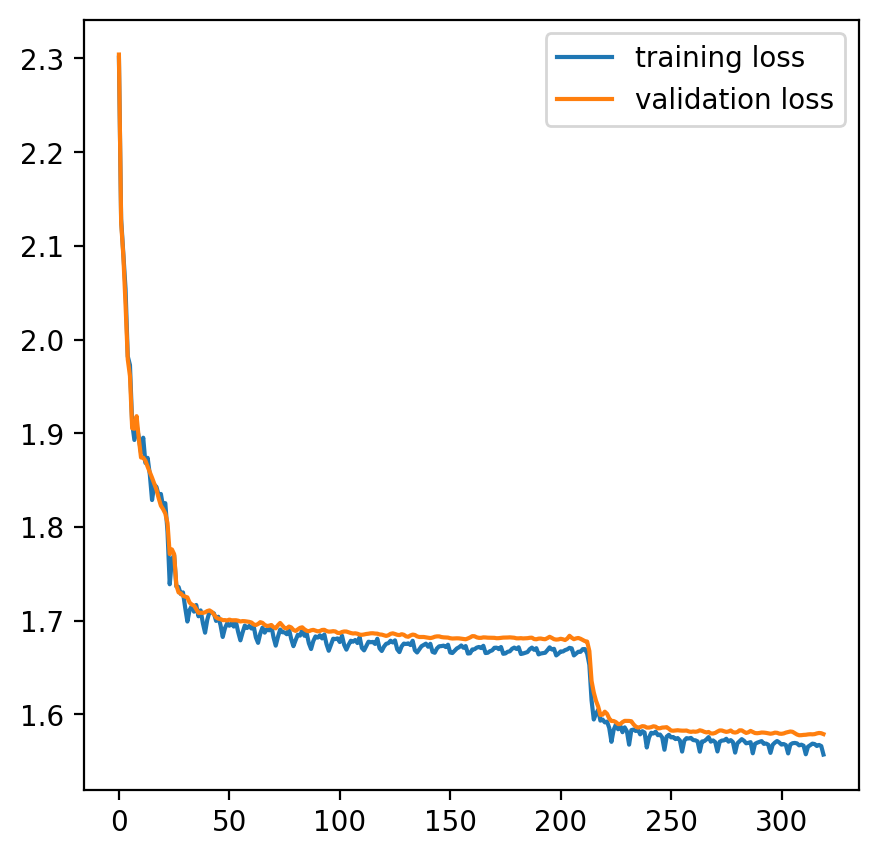

In [43]:
learn_plot(net=net1, opt=opt, loss=loss, batch_size=8192, epochs=40 )

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')


<Axes: >

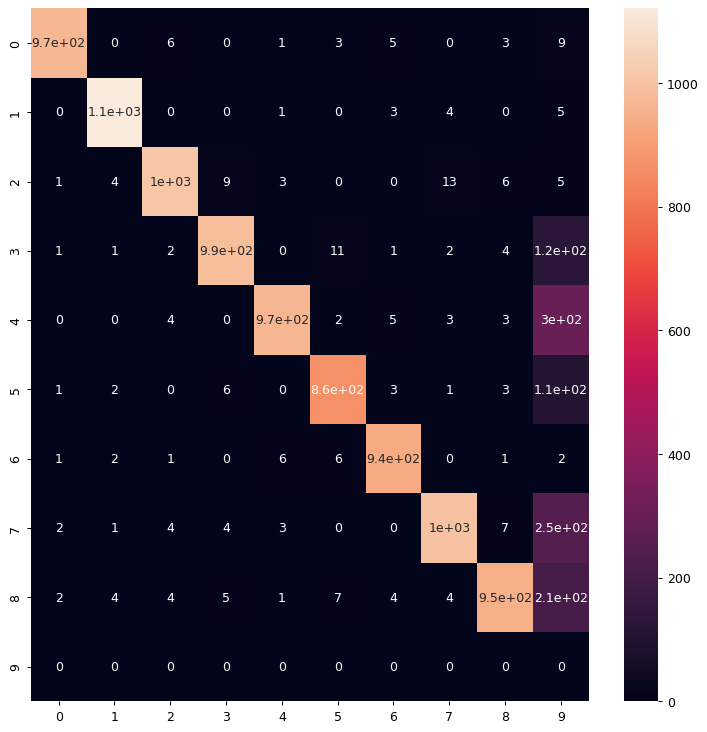

In [50]:


y_pred = net1.predict(X_test).data.max(1)[1]
print(y_pred)
cm = confusion_matrix(y_pred.detach().cpu().numpy(),y_test.detach().cpu().numpy())
plt.figure(figsize = (10,10),dpi=90)
seaborn.heatmap(cm,annot=True)

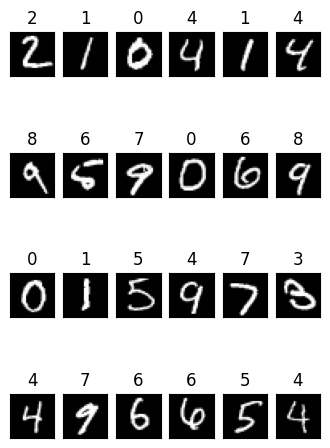

In [45]:
#visulaizing numbers in our dataset.
r = 4
c = 6
fig=plt.figure(figsize=(r, c),dpi=100)
for i in range(1, r*c+1):
    img = X_test.detach().cpu().numpy()[i].reshape(28, 28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(y_pred.detach().cpu().numpy()[i])
    
    plt.imshow(img,cmap='gray')
plt.show()

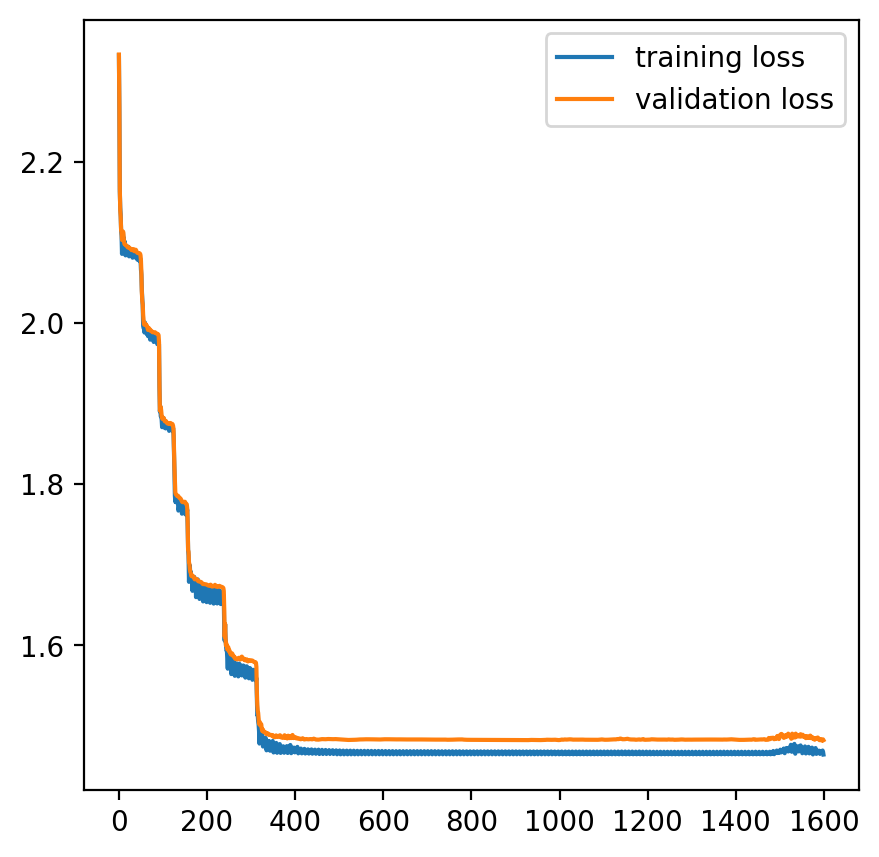

In [46]:
net2 = MNISTnet()
net2 = net2.to(device)
opt = torch.optim.Adam(net2.parameters(), lr = 0.001)
learn_plot(net=net2, opt=opt, loss=loss, batch_size=8192, epochs=200 )

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')


<Axes: >

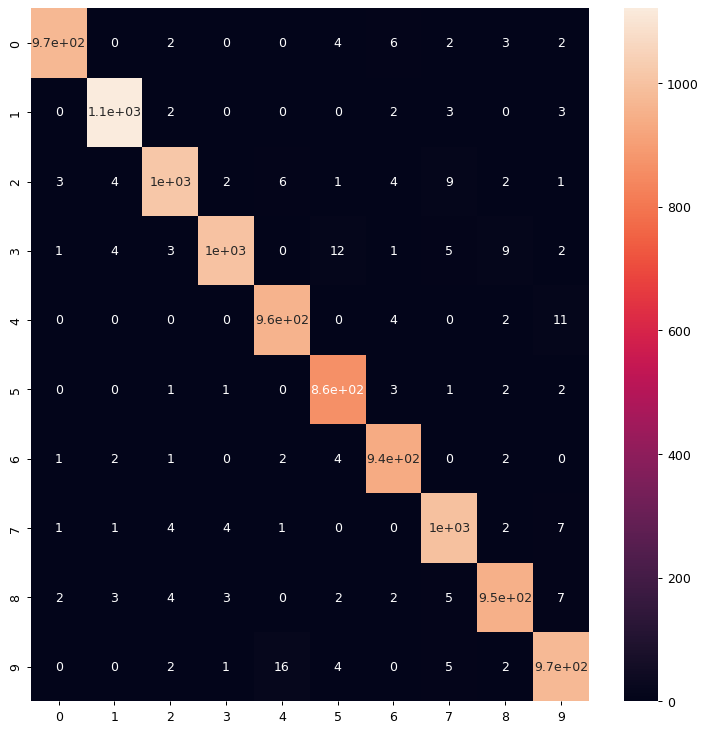

In [51]:
y_pred = net2.predict(X_test).data.max(1)[1]
print(y_pred)
cm = confusion_matrix(y_pred.detach().cpu().numpy(),y_test.detach().cpu().numpy())
plt.figure(figsize = (10,10),dpi=90)
seaborn.heatmap(cm,annot=True)

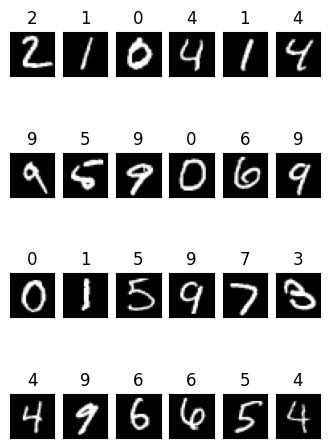

In [52]:
#visulaizing numbers in our dataset.
r = 4
c = 6
fig=plt.figure(figsize=(r, c),dpi=100)
for i in range(1, r*c+1):
    img = X_test.detach().cpu().numpy()[i].reshape(28, 28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(y_pred.detach().cpu().numpy()[i])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [47]:
# batch_size = 64
# epochs = 10

# trn_loss = []
# val_loss = []

# '''данные тренировочной выборки будем перекладывать на cuda по батчам'''
# for epoch in range(epochs):
#   order = np.random.permutation(len(X_train))
#   for start_index in range (0,len(X_train), batch_size):
#     opt.zero_grad()#зануляем градиенты

#     #далее загружаем данные в forward (Получаем выходы сети)
#     y_pred = net.predict(X_train[start_index:start_index+batch_size])

#     loss_tr = loss(y_pred, y_train[start_index:start_index+batch_size])
#     trn_loss.append(loss_tr.cpu().data.item())
    
#     y_pred = net.predict(X_test)
#     loss_val = loss(y_pred, y_test)
#     val_loss.append(loss_val.cpu().data.item())
    
#     loss_tr.backward()

#     opt.step()


In [48]:
# plt.figure(figsize=(5,5),dpi=200)
# plt.plot(trn_loss,label='training loss')
# plt.plot(val_loss,label='validation loss')
# plt.legend(loc='upper right')

###Задание


1.   Дописать код после фразы Ваш_Код_Здесь.
2.   Поэкспериментировать с гиперпараметрами нейронной сети, чтобы добиться более высокой точности классификации.
4.   Построить на одном графике loss для тестовой выборки и для обучающей.
5.   Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации?
7.   Показать результат работы модели с использованием функции predict (необходимо написать функцию predict).
